In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

from sklearn.model_selection import train_test_split

import numpy as np

import pandas as pd

from math import pow, floor

from PIL import Image

import matplotlib.pyplot as plt

import os.path
import os

from pathlib import Path

In [2]:
%matplotlib inline

In [3]:
# config
DATA_DIR = "./dataset2/"
IMG_WIDTH = 175
IMG_HEIGHT = 70
BATCH_SIZE = 70

In [4]:
# loading data
data_dir = Path(DATA_DIR)
images = list(map(str, list(data_dir.glob("*.png"))))
labels = [str(img).split(os.path.sep)[1].split(".")[0][:4] for img in images]
labels = list(map(str.lower, labels))
characters = sorted(set([char for label in labels for char in label]))

In [5]:
# config 
MAX_LENGTH = max(map(len, labels))

In [6]:
# train, validation, test split
train_images, valid_images, train_labels, valid_labels = train_test_split(np.array(images),np.array(labels), test_size=0.05)
# valid_images, test_images, valid_labels, test_labels = train_test_split(np.array(valid_images),np.array(valid_labels), test_size=0.5)

In [7]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters))

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

def encode_single_sample(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# test_dataset = (
#     test_dataset.map(
#         encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
#     )
#     .batch(BATCH_SIZE)
#     .prefetch(buffer_size=tf.data.AUTOTUNE)
# )

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_dataset = (
    valid_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

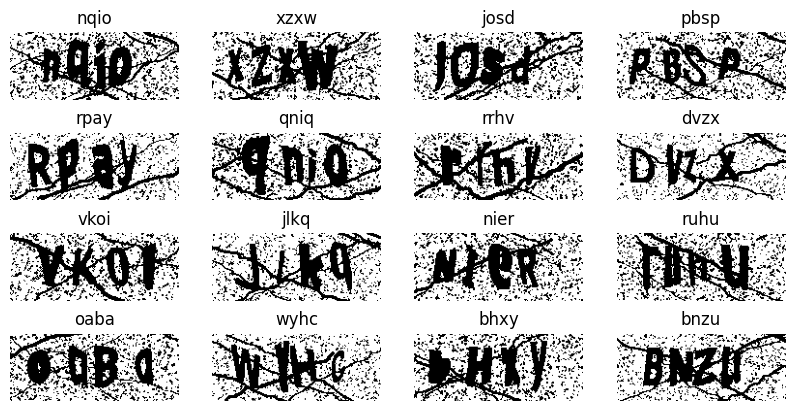

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in valid_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [9]:
# CTC loss function
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(tf.keras.backend.sum(loss))

        # At test time, just return the computed predictions
        return y_pred
    
regul_size = 0.0001

def residual_block(x, filters, kernel_size):
    y = layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal",padding="same", use_bias=False, kernel_regularizer=l2(regul_size))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    
    y = layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal",padding="same", use_bias=False, kernel_regularizer=l2(regul_size))(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    
    layer = layers.Add()([x, y])
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)
    
    return layer
    
    
def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    # First conv block
    x = layers.BatchNormalization()(input_img)
    x = layers.Conv2D(32, (3, 3), kernel_initializer="he_normal",padding="same",name="Conv1", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = residual_block(x, 32, (3,3))
    x = residual_block(x, 32, (3,3))

    # Second conv block
    x = layers.Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv2", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = residual_block(x, 64, (3,3))
    x = residual_block(x, 64, (3,3))
    
    # Third conv block
    x = layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv3", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    x = residual_block(x, 128, (3,3))
    x = residual_block(x, 128, (3,3))

    # Forth conv block
    x = layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv4", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
        
    x = residual_block(x, 256, (3,3))
    x = residual_block(x, 256, (3,3))
    
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((IMG_WIDTH // 8), (IMG_HEIGHT // 8) * 256)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    x = layers.Dense(64, activation="relu", name="dense3")(x)
#     x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [10]:
epochs = 20
early_stopping_patience = 2

# Add early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

def step_decay(epoch):
    initial_lr = 0.005
    drop = 0.5
    epochs = 2
    lr_rate = initial_lr * pow(drop,  
           floor((1+epoch)/epochs))
    return lr_rate

lr_rate = LearningRateScheduler(step_decay)

model = build_model()
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_rate],
)

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 175, 70, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 175, 70, 1)  4           ['image[0][0]']                  
 alization)                                                                                       
                                                                                                  
 Conv1 (Conv2D)                 (None, 175, 70, 32)  288         ['batch_normalization[0][0]']    
                                                                                       

 add_2 (Add)                    (None, 87, 35, 64)   0           ['re_lu_7[0][0]',                
                                                                  're_lu_9[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 87, 35, 64)  256         ['add_2[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 re_lu_10 (ReLU)                (None, 87, 35, 64)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 87, 35, 64)   36864       ['re_lu_10[0][0]']               
                                                                                                  
 batch_nor

 Conv4 (Conv2D)                 (None, 43, 17, 256)  294912      ['re_lu_20[0][0]']               
                                                                                                  
 batch_normalization_22 (BatchN  (None, 43, 17, 256)  1024       ['Conv4[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 re_lu_21 (ReLU)                (None, 43, 17, 256)  0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 pool3 (MaxPooling2D)           (None, 21, 8, 256)   0           ['re_lu_21[0][0]']               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 21, 8, 256)   589824      ['pool3[0][0]']                  
          

Epoch 10/20
3270/7780 [===========>..................] - ETA: 15:42 - loss: 27.4045

KeyboardInterrupt: 

In [13]:
# save model
model.save("models/loss")

INFO:tensorflow:Assets written to: models/loss_33_7_succes_85_1\assets


INFO:tensorflow:Assets written to: models/loss_33_7_succes_85_1\assets


In [ ]:
# load model
model2 = keras.models.load_model("models/loss_33_7_succes_85_1/")

In [11]:
ULOZTO_DIR = "./original_captcha/bw/"
data_dir = Path(ULOZTO_DIR)
ulozto_images = list(map(str, list(data_dir.glob("*.png"))))
ulozto_labels = [str(img).split(os.path.sep)[2].split(".")[0] for img in ulozto_images]

ulozto_dataset = tf.data.Dataset.from_tensor_slices((ulozto_images, ulozto_labels))
ulozto_dataset = (
    ulozto_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

1/1 [==============================] - 1s 1s/step


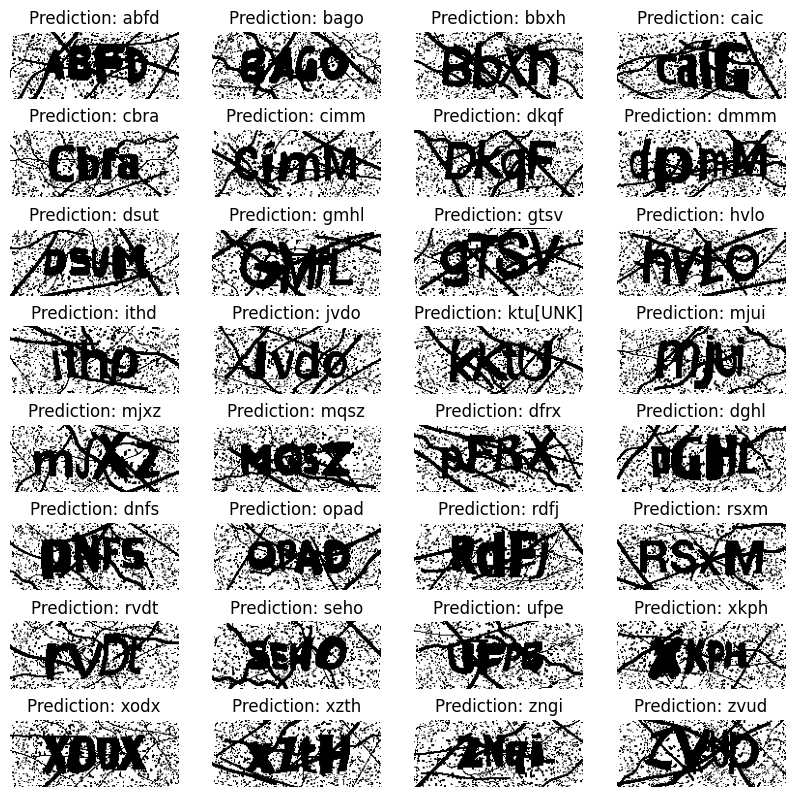

In [12]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
# prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :MAX_LENGTH]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in ulozto_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
        
    _, ax = plt.subplots(8, 4, figsize=(10, 10))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Records

## Dataset2 - 314 269
**Success rate:** 62,5 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 3
## Dataset2 - 413 467
**Success rate:** 51,5 % (16 original test samples)<br>
**100 %** - 1<br>
**75 %** - 5
## Dataset2 - 413 467 (5th conv added, filters adjusted)
**Success rate:** 71,8 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 5
## Dataset2 - 413 467 (regul_size = 0.0001)
**Success rate:** 68,8 % (16 original test samples)<br>
**100 %** - 4<br>
**75 %** - 6
## Dataset2 - 413 467 (regul_size = 0)
**Success rate:** 70,3 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 5
## Dataset2 - 413 467 (residual blocks added (8))
**Success rate:** 71,8 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 7
## Dataset2 - 566 097 
**Success rate:** 75 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 8
## Dataset2 - 666 097 
**Success rate:** 67,2 % (16 original test samples)<br>
**100 %** - 4<br>
**75 %** - 5
## Dataset2 - 666 097 
**Success rate:** 73,4 % (32 original test samples)<br>
**100 %** - 11<br>
**75 %** - 10
## Dataset2 - 573 237 (regul_size = 0.0001)
**Success rate:** 85,1 % (32 original test samples)<br>
**100 %** - 17<br>
**75 %** - 12